In [1]:
import numpy as np
import pandas as pd

In [6]:
def read_dataset(filename, column_name):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)
    elif filename.endswith('.json'):
        df = pd.read_json(filename)
        
    df['Length'] = df[column_name].str.len()
    print(df.head())
    print()
    print(df['Length'].hist(bins=100))
    print()
    print(f"Total # jokes: {df.shape[0]}")
    return df

In [8]:
def select_QA_jokes(df, column_name):
    what_jokes = df[df[column_name].str.lower().str.startswith("what")][column_name].str.split("?", n=1)
    how_jokes = df[df[column_name].str.lower().str.startswith("how")][column_name].str.split("?", n=1)
    why_jokes = df[df[column_name].str.lower().str.startswith("why")][column_name].str.split("?", n=1)
    when_jokes = df[df[column_name].str.lower().str.startswith("when")][column_name].str.split("?", n=1)
    where_jokes = df[df[column_name].str.lower().str.startswith("where")][column_name].str.split("?", n=1)
    return what_jokes, how_jokes, why_jokes, when_jokes, where_jokes

In [2]:
def save_text_to_file(jokes_df, list_of_names, output_file):
    if len(list_of_names) == 2:  # for the case when Q and A are in different columns
        jokes_list = (jokes_df[list_of_names[0]] + ' ' + jokes_df[list_of_names[1]]).values.tolist()
    else:
        jokes_list = (jokes_df[list_of_names[0]]).values.tolist()
    
    processed_jokes_list = []
    for joke in jokes_list:
        processed_joke = joke.replace('\n', ' ').replace('\r', ' ')
        if not processed_joke:  # if the string is empty at this point - don't take it
            continue
        processed_jokes_list.append(processed_joke)
    
    jokes = "\n".join(processed_jokes_list)

    with open(output_file, 'w') as file:
        file.write(jokes)

In [15]:
def save_QA_with_special_symbols(df, output_name):
    jokes_list = ("<soq> " + df.question + " <eoq> " + df.answer + " <|endoftext|>").values.tolist()
    processed_jokes_list = []

    for joke in jokes_list:
        processed_joke = joke.replace('\n', ' ').replace('\r', ' ')
        processed_jokes_list.append(processed_joke)

    clean_jokes = "\n".join(processed_jokes_list)

    with open(output_name, "w") as f:
        f.write(clean_jokes)

## Explore & preprocess kaggle dataset

   ID                                               Joke  Length
0   1  [me narrating a documentary about narrators] "...      95
1   2  Telling my daughter garlic is good for you. Go...     118
2   3  I've been going through a really rough period ...     120
3   4  If I could have dinner with anyone, dead or al...      90
4   5     Two guys walk into a bar. The third guy ducks.      46

AxesSubplot(0.125,0.125;0.775x0.755)

Total # jokes: 231657


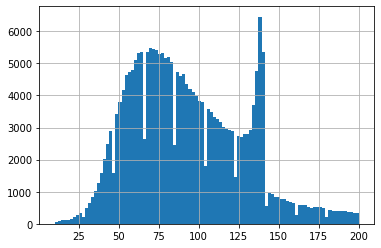

In [7]:
kaggle_df = read_dataset('./datasets/intermediate/kaggle_shortjokes.csv', 'Joke')

In [9]:
save_text_to_file(kaggle_df, ['Joke'], './datasets/intermediate/kaggle_plain')

In [9]:
what_jokes, how_jokes, why_jokes, when_jokes, where_jokes = select_QA_jokes(kaggle_df, 'Joke')

In [12]:
# split into two columns, questions and answers, and drop the ones without any answer
jokes = []
for joke_ in [what_jokes, how_jokes, why_jokes, when_jokes, where_jokes]:
    joke_df_ = pd.DataFrame(joke_.values.tolist()).iloc[:, :2].dropna()
    joke_df_.columns = ["question", "answer"]
    jokes.append(joke_df_)

jokes_df = pd.concat(jokes)
jokes_df = (jokes_df[~(jokes_df.answer.isin([""]))].drop_duplicates().reset_index(drop=True))

In [46]:
save_text_to_file(jokes_df, ["question", "answer"], './datasets/intermediate/kaggle_QA')

In [16]:
save_QA_with_special_symbols(jokes_df, './datasets/intermediate/kaggle_QA_with_special_symbols')

## Exlpore & preprocess reddit jokes

In [10]:
reddit_jokes = './datasets/reddit_jokes.json'

In [11]:
# can't use the function for reading and info because this dataset has two columns for a joke: body and title
reddit_df = pd.read_json(reddit_jokes)

In [12]:
reddit_df['Length'] = reddit_df['body'].str.len() + reddit_df['title'].str.len()

In [13]:
reddit_df.head(10)

,body,id,score,title,Length
0,"Now I have to say ""Leroy can you please paint ...",5tz52q,1,I hate how you cant even say black paint anymore,105
1,Pizza doesn't scream when you put it in the ov...,5tz4dd,0,What's the difference between a Jew in Nazi Ge...,128
2,...and being there really helped me learn abou...,5tz319,0,I recently went to America....,204
3,A Sunday school teacher is concerned that his ...,5tz2wj,1,"Brian raises his hand and says, “He’s in Heaven.”",577
4,He got caught trying to sell the two books to ...,5tz1pc,0,You hear about the University book store worke...,157
5,Because the p is silent.,5tz1o1,0,Why is it unknown on how pterodactyls urinate ...,95
6,To avoid leaving tracks like a snail while wal...,5tz0ef,0,Why women need legs?,71
7,"Apparently ""Whatever's low in cholesterol"" was...",5tz04j,1,I walked into a PETA adoption center and the r...,160
8,Character actors!,5tz02q,0,How did TV studios make words appear on screen...,81
9,You follow his fresh prints.,5tz02h,0,How do you find Will Smith in the snow?,68


In [14]:
reddit_df.shape[0]

194553

In [93]:
save_text_to_file(reddit_df, ['title', 'body'], './datasets/intermediate/reddit_plain')

<AxesSubplot:>

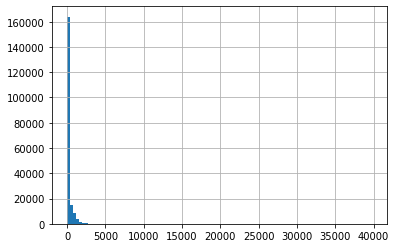

In [16]:
reddit_df['Length'].hist(bins=100)  # histogram of jokes' lengths

In [17]:
# the kaggle dataset contained only jokes of len <200, so we'll do the same for this one
shorter_reddit_jokes_df = reddit_df[reddit_df['Length'] < 200]

<AxesSubplot:>

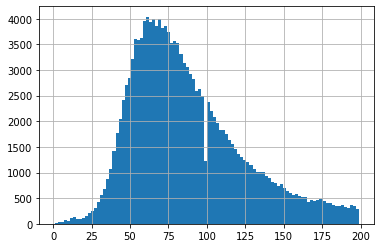

In [19]:
shorter_reddit_jokes_df['Length'].hist(bins=100)

In [94]:
save_text_to_file(shorter_reddit_jokes_df, ['title', 'body'], './datasets/intermediate/reddit_plain_200')

In [81]:
# leave only jokes that start with what how why when where
# this is also a bit different from what we did for the first dataset
what_jokes = shorter_reddit_jokes_df[shorter_reddit_jokes_df.title.str.lower().str.startswith("what")]
how_jokes = shorter_reddit_jokes_df[shorter_reddit_jokes_df.title.str.lower().str.startswith("how")]
why_jokes = shorter_reddit_jokes_df[shorter_reddit_jokes_df.title.str.lower().str.startswith("why")]
when_jokes = shorter_reddit_jokes_df[shorter_reddit_jokes_df.title.str.lower().str.startswith("when")]
where_jokes = shorter_reddit_jokes_df[shorter_reddit_jokes_df.title.str.lower().str.startswith("where")]

In [82]:
# leave two columns, questions and answers, and drop the ones without any answer
jokes = []
for joke_ in [what_jokes, how_jokes, why_jokes, when_jokes, where_jokes]:
    joke_df_ = pd.DataFrame(joke_.values.tolist()).iloc[:, [0, 3]].dropna()
    joke_df_.columns = ["answer", "question"]
    jokes.append(joke_df_)

jokes_df = pd.concat(jokes)
jokes_df = (jokes_df[~(jokes_df.answer.isin([""]))].drop_duplicates().reset_index(drop=True))

In [51]:
save_text_to_file(jokes_df, ["question", "answer"], './datasets/intermediate/reddit_QA')

In [83]:
save_QA_with_special_symbols(jokes_df, './datasets/intermediate/reddit_QA_with_special_symbols')

## Explore & preprocess stupidstuff jokes

                                                body      category  id  \
0  A blackjack dealer and a player with a thirtee...      Children   1   
1  At a dinner party, several of the guests were ...  Blonde Jokes   2   
2  One day this cop pulls over a blonde for speed...  Blonde Jokes   3   
3  Three women are about to be executed for crime...  Blonde Jokes   4   
4  A girl came skipping home FROM school one day....  Blonde Jokes   5   

   rating  Length  
0    2.63     534  
1    2.57     446  
2    3.09     224  
3    4.10     892  
4    4.30     987  

AxesSubplot(0.125,0.125;0.775x0.755)

Total # jokes: 3773


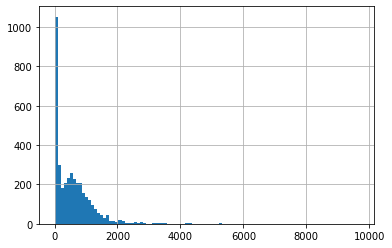

In [17]:
stupidstuff_df = read_dataset('./datasets/intermediate/stupidstuff.json', 'body')

In [24]:
save_text_to_file(stupidstuff_df, ['body'], './datasets/intermediate/stupidstuff_plain')

<AxesSubplot:>

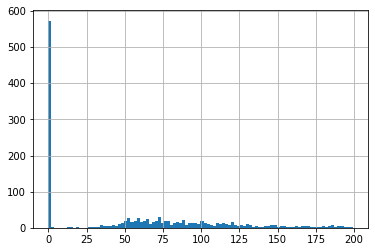

In [18]:
# the kaggle dataset contained only jokes of len <200, so we'll do the same for this one
shorter_stupidstuff_df = stupidstuff_df[stupidstuff_df['Length'] < 200]
shorter_stupidstuff_df['Length'].hist(bins=100)

In [28]:
save_text_to_file(shorter_stupidstuff_df, ['body'], './datasets/intermediate/stupidstuff_plain_200')

In [19]:
what_jokes, how_jokes, why_jokes, when_jokes, where_jokes = select_QA_jokes(shorter_stupidstuff_df, 'body')

In [85]:
jokes = []
for joke_ in [what_jokes, how_jokes, why_jokes, when_jokes, where_jokes]:
    if joke_.empty:
        continue
    joke_df_ = pd.DataFrame(joke_.values.tolist()).dropna()
    joke_df_.columns = ["question", "answer"]
    jokes.append(joke_df_)

jokes_df = pd.concat(jokes)
jokes_df = (jokes_df[~(jokes_df.answer.isin([""]))].drop_duplicates().reset_index(drop=True))

In [58]:
save_text_to_file(jokes_df, ["question", "answer"], './datasets/intermediate/stupidstuff_QA')

In [86]:
save_QA_with_special_symbols(jokes_df, './datasets/intermediate/stupidstuff_QA_with_special_symbols')

## Explore & preprocess wocka jokes

                                                body      category  id  \
0  What do you call a cow with no legs?\r\n\r\nGr...        Animal   1   
1  What do you call a cow jumping over a barbed w...        Animal   2   
2  What's black and white and red all over?\r\n\r...  Other / Misc   4   
3  So, this guy walks into a bar.\r\n\r\nAnd says...           Bar   5   
4  If the opposite of pro is con, isn't the oppos...    One Liners   6   

                  title  Length  
0      Cow With No Legs      52  
1           Jumping Cow      78  
2  Black, White and Red      56  
3          Guy in a Bar      51  
4              Progress      72  

AxesSubplot(0.125,0.125;0.775x0.755)

Total # jokes: 10019


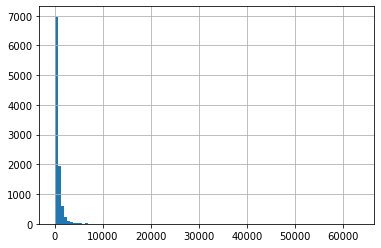

In [24]:
wocka_df = read_dataset('./datasets/intermediate/wocka.json', 'body')

In [33]:
save_text_to_file(wocka_df, ['body'], './datasets/intermediate/wocka_plain')

In [22]:
# again, delete jokes bigger than 200 symbols
shorter_wocka_df = wocka_df[wocka_df['Length'] < 200]

<AxesSubplot:>

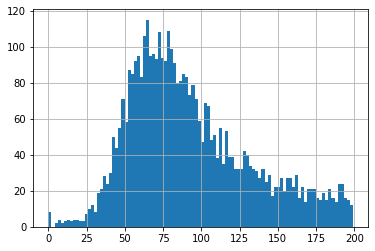

In [35]:
shorter_wocka_df['Length'].hist(bins=100)

In [36]:
save_text_to_file(shorter_wocka_df, ['body'], './datasets/intermediate/wocka_plain_200')

In [23]:
what_jokes, how_jokes, why_jokes, when_jokes, where_jokes = select_QA_jokes(shorter_wocka_df, 'body')

In [88]:
jokes = []
for joke_ in [what_jokes, how_jokes, why_jokes, when_jokes, where_jokes]:
    if joke_.empty:
        continue
    joke_df_ = pd.DataFrame(joke_.values.tolist()).dropna()
    joke_df_.columns = ["question", "answer"]
    jokes.append(joke_df_)

jokes_df = pd.concat(jokes)
jokes_df = (jokes_df[~(jokes_df.answer.isin([""]))].drop_duplicates().reset_index(drop=True))

In [62]:
save_text_to_file(jokes_df, ["question", "answer"], './datasets/intermediate/wocka_QA')

In [89]:
save_QA_with_special_symbols(jokes_df, './datasets/intermediate/wocka_QA_with_special_symbols')

## Explore & preprocess semeval jokes

   id                                               text  is_humor  \
0   1  TENNESSEE: We're the best state. Nobody even c...         1   
1   2  A man inserted an advertisement in the classif...         1   
2   3  How many men does it take to open a can of bee...         1   
3   4  Told my mom I hit 1200 Twitter followers. She ...         1   
4   5  Roses are dead. Love is fake. Weddings are bas...         1   

   humor_rating  humor_controversy  offense_rating  Length  
0          2.42                1.0             0.2     114  
1          2.50                1.0             1.1     189  
2          1.95                0.0             2.4     112  
3          2.11                1.0             0.0     139  
4          2.78                0.0             0.1      72  

AxesSubplot(0.125,0.125;0.775x0.755)

Total # jokes: 8000


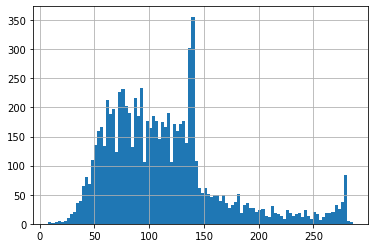

In [25]:
semeval_df = read_dataset('./datasets/intermediate/semeval.csv', 'text')

In [41]:
save_text_to_file(semeval_df, ['text'], './datasets/intermediate/semeval_plain')

In [26]:
shorter_semeval_df = semeval_df[semeval_df['Length'] < 200]

In [43]:
save_text_to_file(shorter_semeval_df, ['text'], './datasets/intermediate/semeval_plain_200')

In [27]:
what_jokes, how_jokes, why_jokes, when_jokes, where_jokes = select_QA_jokes(shorter_semeval_df, 'text')

In [91]:
jokes = []
for joke_ in [what_jokes, how_jokes, why_jokes, when_jokes, where_jokes]:
    if joke_.empty:
        continue
    joke_df_ = pd.DataFrame(joke_.values.tolist()).dropna()
    joke_df_.columns = ["question", "answer"]
    jokes.append(joke_df_)

jokes_df = pd.concat(jokes)
jokes_df = (jokes_df[~(jokes_df.answer.isin([""]))].drop_duplicates().reset_index(drop=True))

In [68]:
save_text_to_file(jokes_df, ["question", "answer"], './datasets/intermediate/semeval_QA')

In [92]:
save_QA_with_special_symbols(jokes_df, './datasets/intermediate/semeval_QA_with_special_symbols')